# GENDER RECOGNITION BASED ON VOICE #
**Gizem Burcu Çınar Pala**
**April, 2021**<br><br><br>

In this project, recognition of gender based on voice problem has been approached in two ways. For two approach, Mel-frequency cepstrum coefficients (MFCC) are gathered for two genders. For second step that is classification, two models (GMM (Gaussian Mixture Model) and K-means algorithms) are created for each genders by using MFCC. The performances of the two models are compared with the test dataset.


## General Outline

The steps below are followed in order to solve the problem mentioned above.

### Training Part :
**1)** Extract All Voice Sample<br>
**2)** Seperate them based on gender with shuffling<br>
**3)** Train Female file (2/3 of dataset)<br>
-  Feature Extraction: Extract Mel Frequency Cepstral Coefficient<br>
-  Create a Model:  Train GMM models basen on MFCC<br>
-  Create a Model:  Train Kmeans models basen on MFCC<br>

**4)** Save models for two genders as Females and Males  <br>

### Testing Part:
**1)**	Feature Extraction: Extract Mel Frequency Cepstral Coefficient for testing sample<br>
**2)**	Compute likelihoods score by using Males GMM model<br>
**3)**	Compute likelihoods score by using Females GMM model<br>
**4)**	Compare scores<br>
**5)**	Decission male or female according to comparing scores. Biggest one is winner<br>
**6)**	Repeate all steps for Kmeans models<br>


Starting to set up all of the necessary libraries loading all of the Python modules we will need.

In [2]:
# import libararies
import os
import sys
import numpy as np
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import scipy.signal
from  scipy.io.wavfile import read

from IPython.display import Audio
from python_speech_features import mfcc
from python_speech_features import delta

import librosa.display

import pickle
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

## STEP 1) DATA EXPLORER 

   In this step sample voice datas are divided by gender info. Then all datas are shuffled and splited to the training and testing sets for each gender. Training data is 2/3 and test data is  1/3 of dataset. This step is run only once to prepare input data.<br>
Dataset consists of 3842(2186 female/1656 male) voice sample.   



In [3]:
# Data Explorer
pwd = r'C:\Users\TCGCINAR\Desktop\Udacity_MachineLearningNanoDegree\Final Project'
dataset_dir = pwd + "\\ST-AEDS-20180100_1-OS"

In [3]:
# select females files and males files
file_names   = [fname for fname in os.listdir(dataset_dir) if ("f0" in fname or "m0" in fname)]
#dataset consists of 3842(2186 female/1656 male) voice sample
print(len(file_names))

3842


In [4]:
# get wav file name by gender and fill dictionary
dataset_dict = { 'f' : [] , 'm' : []}
for fname in file_names:
    dataset_dict[fname[0]].append(fname)

In [5]:
#Create test and train folder
os.mkdir(pwd + "\\TrainingData")
os.mkdir(pwd + "\\TestingData")
os.mkdir(pwd + "\\TrainingData\\females")
os.mkdir(pwd + "\\TrainingData\\males")
os.mkdir(pwd + "\\TestingData\\females")
os.mkdir(pwd + "\\TestingData\\males")

In [6]:
#Shuffle voice records and split the training and test sets by gender
female_train, female_test = train_test_split( shuffle(np.array(dataset_dict['f'])), test_size=0.33)
male_train, male_test = train_test_split( shuffle(np.array(dataset_dict['m'])), test_size=0.33)

In [7]:
#move wav file to new directory
for file in female_train:
    shutil.move(os.path.join(dataset_dir, file), (pwd + "\\TrainingData\\females"))

for file in female_test:
    shutil.move(os.path.join(dataset_dir, file), (pwd + "\\TestingData\\females"))
    
for file in male_train:
    shutil.move(os.path.join(dataset_dir, file), (pwd + "\\TrainingData\\males"))

for file in male_test:
    shutil.move(os.path.join(dataset_dir, file), (pwd + "\\TestingData\\males"))

### Wav files, sampling
Read a wav file, get its sampling rate and length, and display it to play. The wave data is a single dimensional array.

In [8]:
filename = pwd + r'\TrainingData\females\f0001_us_f0001_00003.wav'

fs, wave = read(filename)  # read a wav file

print('Data:', wave)
print('Sampling rate:', fs)
print('Audio length:', wave.size/fs, 'seconds')
print('Lowest amplitude:', min(wave))
print('Highest amplitude:', max(wave))

Audio(filename) # play a wav file

Data: [0 0 0 ... 1 1 1]
Sampling rate: 16000
Audio length: 2.64 seconds
Lowest amplitude: -3229
Highest amplitude: 3483


In [9]:
#funciton to plot wave file
def plotwave(fs, signal, maxf=None):
    """Visualize a wave file."""
    # maxf = maximum number of frames
    frames = scipy.arange(signal.size)   # x-axis
    if maxf:
        plt.plot(frames[:maxf], signal[:maxf])
        plt.xticks(scipy.arange(0, maxf, 0.5*fs), scipy.arange(0, maxf/fs, 0.5))
        plt.show()
    else:
        plt.plot(frames, signal)
        plt.xticks(scipy.arange(0, signal.size, 0.5*fs), scipy.arange(0, signal.size/fs, 0.5))
        plt.show()

<ipython-input-9-45baecebc8f0>:5: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  frames = scipy.arange(signal.size)   # x-axis
<ipython-input-9-45baecebc8f0>:12: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  plt.xticks(scipy.arange(0, signal.size, 0.5*fs), scipy.arange(0, signal.size/fs, 0.5))


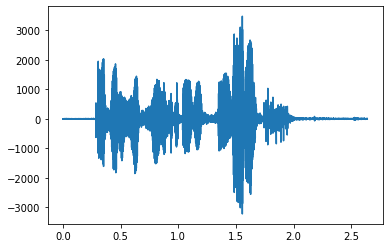

In [10]:
plotwave(fs, wave)

## STEP 2) FEATURE EXTRACTION

### Mel Frequency Cepstral Coefficient (MFCC)

The first step in any automatic speech recognition system is to extract features i.e. identify the components of the audio signal that are good for identifying the linguistic content and discarding all the other stuff which carries information like background noise, emotion etc.

The main point to understand about speech is that the sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. This shape determines what sound comes out. If we can determine the shape accurately, this should give us an accurate representation of the phoneme being produced. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope

Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition. They were introduced by Davis and Mermelstein in the 1980's, and have been state-of-the-art ever since. Prior to the introduction of MFCCs, Linear Prediction Coefficients (LPCs) and Linear Prediction Cepstral Coefficients (LPCCs) (click here for a tutorial on cepstrum and LPCCs) and were the main feature type for automatic speech recognition (ASR), especially with HMM classifiers

#### Steps at a Glance 
Implementation steps of MFCC are given below <br><br>

**1)** Frame the signal into short frames. <br>
**2)** For each frame calculate the periodogram estimate of the power spectrum.<br>
**3)** Apply the mel filterbank to the power spectra, sum the energy in each filter.<br>
**4)** Take the logarithm of all filterbank energies.<br>
**5)** Take the DCT of the log filterbank energies.<br>
**6)** Keep DCT coefficients 2-13, discard the rest.<br>
**7)** There are a few more things commonly done, sometimes the frame energy is appended to each feature vector. Delta and Delta-Delta features are usually also appended.<br>


#### Why do we do these things? 

We will now go a little more slowly through the steps and explain why each of the steps is necessary.<br><br>

- An audio signal is constantly changing, so to simplify things we assume that on short time scales the audio signal doesn't change much. This is why we frame the signal into 20-40ms frames. If the frame is much shorter we don't have enough samples to get a reliable spectral estimate, if it is longer the signal changes too much throughout the frame.<br><br>

- The next step is to calculate the power spectrum of each frame. This is motivated by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. Depending on the location in the cochlea that vibrates (which wobbles small hairs), different nerves fire informing the brain that certain frequencies are present. Our periodogram estimate performs a similar job for us, identifying which frequencies are present in the frame.<br><br>

- The periodogram spectral estimate still contains a lot of information not required for Automatic Speech Recognition (ASR). In particular the cochlea can not discern the difference between two closely spaced frequencies. This effect becomes more pronounced as the frequencies increase. For this reason we take clumps of periodogram bins and sum them up to get an idea of how much energy exists in various frequency regions. This is performed by our Mel filterbank: the first filter is very narrow and gives an indication of how much energy exists near 0 Hertz. As the frequencies get higher our filters get wider as we become less concerned about variations. We are only interested in roughly how much energy occurs at each spot. The Mel scale tells us exactly how to space our filterbanks and how wide to make them. See below for how to calculate the spacing.<br><br>

- Once we have the filterbank energies, we take the logarithm of them. This is also motivated by human hearing: we don't hear loudness on a linear scale. Generally to double the percieved volume of a sound we need to put 8 times as much energy into it. This means that large variations in energy may not sound all that different if the sound is loud to begin with. This compression operation makes our features match more closely what humans actually hear. Why the logarithm and not a cube root? The logarithm allows us to use cepstral mean subtraction, which is a channel normalisation technique.<br><br>

- The final step is to compute the DCT of the log filterbank energies. There are 2 main reasons this is performed. Because our filterbanks are all overlapping, the filterbank energies are quite correlated with each other. The DCT decorrelates the energies which means diagonal covariance matrices can be used to model the features in e.g. a HMM classifier. But notice that only 12 of the 26 DCT coefficients are kept. This is because the higher DCT coefficients represent fast changes in the filterbank energies and it turns out that these fast changes actually degrade ASR performance, so we get a small improvement by dropping them.<br><br>

#### What is the Mel scale? 
The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear.

The formula for converting from frequency to Mel scale is:

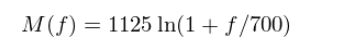



#### Deltas and Delta-Deltas 
Also known as differential and acceleration coefficients. The MFCC feature vector describes only the power spectral envelope of a single frame, but it seems like speech would also have information in the dynamics i.e. what are the trajectories of the MFCC coefficients over time. It turns out that calculating the MFCC trajectories and appending them to the original feature vector increases ASR performance by quite a bit (if we have 12 MFCC coefficients, we would also get 12 delta coefficients, which would combine to give a feature vector of length 24).

To calculate the delta coefficients, the following formula is used:

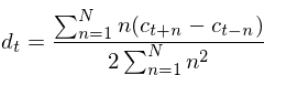

where d(t) is a delta coefficient, from frame t computed in terms of the static coefficients c(t)+N to c(t)-N . A typical value  for N is 2. Delta-Delta (Acceleration) coefficients are calculated in the same way, but they are calculated from the deltas, not the static coefficients.

In [4]:
# Extracting MFCC Function by using python_speech_features library
def extract_Mfcc(wave_path):
    """
    Extract Mel Frequency Cepstral Coefficient (MFCC) of a voice sample
    Args:    
        audio_path (str) : path to wav file
    Returns:   
        combined (array) : Extracted MFCC features
    """
    fs, wave  = read(wave_path)
    mfcc_feature = mfcc(wave, fs, winlen= 0.025, winstep=0.01, numcep=12, nfilt=30, nfft=512,appendEnergy=True)
    
    #wave :    The audio signal to extract features.
    #fs :      The sample rate of the signal
    #winlen :  The length of the analysis window in seconds.(Default is 0.025s)
    #winstep : The step between successive windows in seconds.(Default is 0.01s)
    #numcep  : The number of cepstrum to return. (Default is 13)
    #nfilt   : The number of filters in the filterbank. (Default is 26)
    #nfft    : The FFT size.(Default is 512)
    #appendEnergy : If true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    
    mfcc_feature  = preprocessing.scale(mfcc_feature)  #scaling mfcc 
    deltas        = delta(mfcc_feature, 2)  #calculating differential and acceleration coefficients
    double_deltas = delta(deltas, 2) #calculating differential and acceleration coefficients 
    combined_mfcc      = np.hstack((mfcc_feature, deltas, double_deltas))
    return combined_mfcc

In [5]:
# MFCC for a sample wav file 
combined_mfcc_female = extract_Mfcc(pwd + r'\TrainingData\females\f0001_us_f0001_00003.wav')
combined_mfcc_male = extract_Mfcc(pwd + r'\TrainingData\males\m0001_us_m0001_00005.wav')
print(combined_mfcc_female.shape)  # Shape of combined MFCC

(263, 36)


As seen above, f0001_us_f0001_00003.wav file is splited with 25 ms windowing size and 10 ms windowing step to farmes which is totally 263 frames, then for each frame 12 mfcc is calculated. because of delta function which we used for twice, number of Mfcc are 36.


<function matplotlib.pyplot.show(close=None, block=None)>

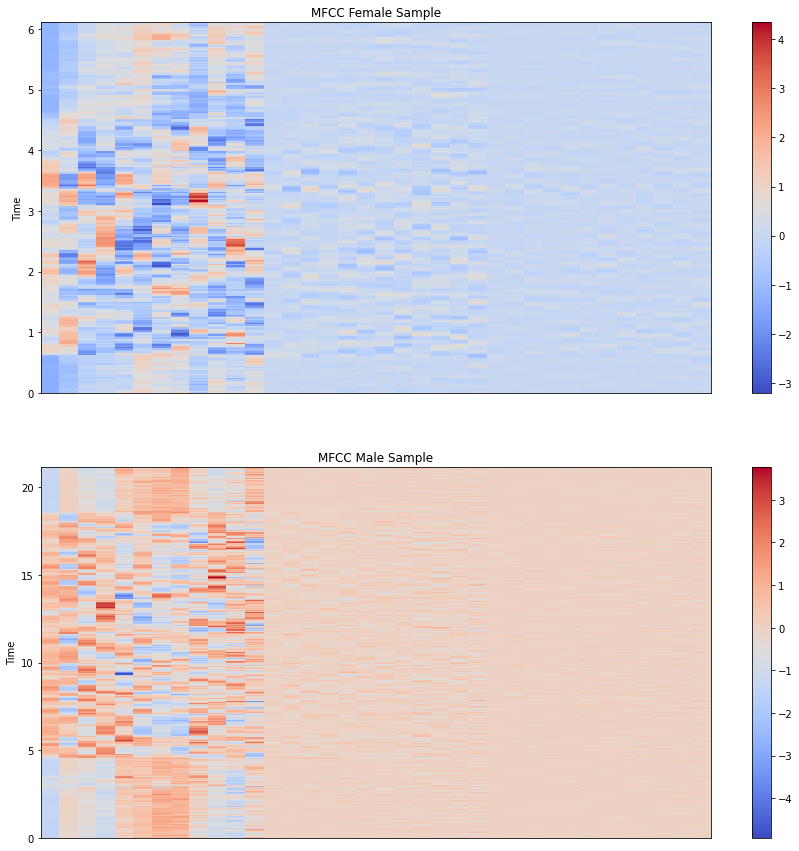

In [6]:
#Display the scaled MFCCs
fig, ax = plt.subplots(2,1,figsize=(15,15)) 
img1 = librosa.display.specshow(combined_mfcc_female, y_axis='time', ax=ax[0])
img2 = librosa.display.specshow(combined_mfcc_male, y_axis='time', ax=ax[1])
fig.colorbar(img1, ax=ax[0])
fig.colorbar(img2, ax=ax[1])

ax[0].set(title='MFCC Female Sample')
ax[1].set(title='MFCC Male Sample')
plt.show  




If a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies.


## STEP 3) MODELLING WITH GMM

#### Gaussian Mixture Model Tutorial

A Gaussian Mixture Model (GMM) is a probability distribution. Where basic distributions like the Gaussian or Cauchy distributions model a single peak, GMMs can model distributions with many peaks. This is achieved by adding several Gaussian together. By using a sufficient number of Gaussians, and by adjusting their means and covariances as well as the weights, almost any continuous density can be approximated to arbitrary accuracy. A mixture of Gaussians can be written as:


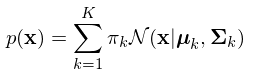

#### The Expectation Maximisation Algorithm 

Finding the optimal gaussian mixture parameters for given a set of observations is performed using the Expectation Maximisation (EM) algorithm. The EM algorithm is a maximum likelyhood approach similar in structure to the k-means algorithm. It is an iterative algorithm with 2 steps per iteration: the expectation (E) step and the maximisation (M) step. The update of the gaussian mixture parameters from an E step followed by an M step is guaranteed to increase the log likelyhood function (the likelyhood that ,  and  are the mixture parameters that generated the given set of observations).

The steps involved in the EM algorithm are listed below.

Initialise the means , covariances  and mixing coefficients , and the initial value of the log likelyhood. The k-means algorithm is commonly used to cluster the given observations, these clusters are then provided as the starting point for the EM algorithm.
E step Evaluate the responsibilities using the current parameter values

M step Re-estimate the parameters using the current responsibilities

where

Evaluate the log likelyhood

Check for convergence of either the parameters or the log likelyhood. If the convergence criterion is not satisfied, return again



### STEP 3.1) SELECT NUMBER OF COMPONENT  OF GMM MODEL

The BIC criterion can be used to select the number of components in a Gaussian Mixture in an efficient way. In theory, it recovers the true number of components only in the asymptotic regime (i.e. if much data is available and assuming that the data was actually generated i.i.d. from a mixture of Gaussian distribution).

#### Bayesian information criterion (BIC)

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have, and by extension, the true, unknown, distribution. In order to avoid overfitting, this technique penalizes models with big number of clusters. In our model number of components is chosen as 16. 

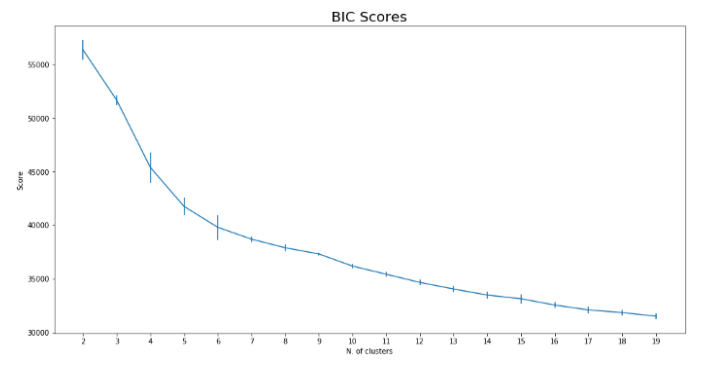



Following this criterion, the bigger the number of clusters, the better should be the model. Which means that the penalty BIC criteria gives to complex models do not save us from overfit. Or, in more prosaic terms, this score sucks. At least in this basic form.

In [7]:
#collect voice features for choosing the best number of conponents 
training_path = pwd + r'\TrainingData\males'
files = os.listdir((training_path))
features = np.asarray(())

for file in files:  
    # extract MFCC & delta MFCC features from audio
    vector = extract_Mfcc( training_path + '\\' + file)
    # stack the features
    if features.size == 0:  
        features = vector
    else:
        features = np.vstack((features, vector)) # all MFCC of training males' voice sample   

In [8]:
#Create GMM Models for 4 <= #component <= 21
n_components = np.arange(4, 21)   
gmm_models = [GMM(n, covariance_type='diag').fit(features)
              for n in n_components]


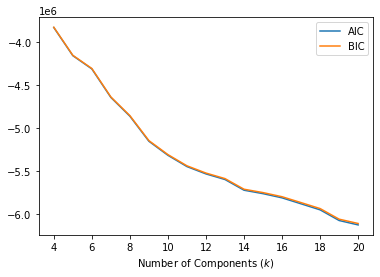

In [9]:
# Compute metrics to determine best hyperparameter
AIC = [m.aic(features) for m in gmm_models]
BIC = [m.bic(features) for m in gmm_models]
# Plot these metrics
plt.plot(n_components, AIC, label='AIC')
plt.plot(n_components, BIC, label='BIC')
plt.xlabel('Number of Components ($k$)')
plt.legend()

As can be seen above, the BIC calculation is made with different componenet values. I think 16 will be most suitable for our model to handle high accuracy

In [ ]:

_, axes = plt.subplots(9, 2, figsize=(200,200), dpi=100)
i = 4 
for gmm, ax in zip(gmm_models, axes.ravel()):
    i += 1
    gmm_labels = gmm.predict(features)
    ax.scatter(features[:,0], features[:,1], c=gmm_labels, cmap='rainbow')
    ax.set_title("number of components = " + str(i))
    
plt.tight_layout()


In [17]:
def create_GMM_model(training_path, model_name):
    """
    Collect voice features from given path
    Args:
        training_path (str) : voice samples file path.
        model_name (str) : created model name
    Returns:
        None
    """
    
    files = os.listdir(training_path)
    features = np.asarray(())
    
    print("Processing............! ")
    for file in files:  # collect voice features
        # extract MFCC & delta MFCC features from audio
        vector = extract_Mfcc( training_path + '\\' + file)
        
        # stack the features
        if features.size == 0:  
            features = vector
        else:
            features = np.vstack((features, vector))    
    

    # generate gaussian mixture models
    gmm_model = GMM(n_components = 16,  covariance_type='diag', n_init = 3)
          
    # fit features to models
    gmm_model.fit(features)

    # save models
    filename = pwd + "\\" + model_name + ".gmm"
    with open(filename, 'wb') as gmm_file:
        pickle.dump(gmm_model, gmm_file)
    print ("%5s %10s" % ("SAVING", filename))
    
    
    

In [18]:
def create_Kmeans_model(training_path, model_name):
    """
    Collect voice features from given path
    Args:
        training_path (str) : voice samples file path.
        model_name (str) : created model name
    Returns:
        None
    """
    files = os.listdir(training_path)
    features = np.asarray(())
    print("Processing............! ")   
    
    for file in files:  # collect voice features
        # extract MFCC & delta MFCC features from audio
        vector = extract_Mfcc( training_path + '\\' + file)
        
        # stack the features
        if features.size == 0:  
            features = vector
        else:                   
            features = np.vstack((features, vector))    
    
    # generate gaussian mixture models
    kmeans_model = KMeans(n_clusters = 16).fit(features)
    
    # save models
    filename = pwd + "\\" + model_name + ".km"
    with open(filename, 'wb') as km_file:
        pickle.dump(kmeans_model, km_file)
    print ("%5s %10s" % ("SAVING", filename))

In [19]:
male_gmm_model = create_GMM_model(pwd + r'\TrainingData\males' , 'male_gmm_model')

Processing............! 
SAVING C:\Users\TCGCINAR\Desktop\Udacity_MachineLearningNanoDegree\Final Project\male_gmm_model.gmm


In [20]:
female_gmm_model = create_GMM_model(pwd + r'\TrainingData\females' , 'female_gmm_model')

Processing............! 
SAVING C:\Users\TCGCINAR\Desktop\Udacity_MachineLearningNanoDegree\Final Project\female_gmm_model.gmm


In [21]:
male_km_model = create_Kmeans_model(pwd + r'\TrainingData\males' , 'male_km_model')

Processing............! 
SAVING C:\Users\TCGCINAR\Desktop\Udacity_MachineLearningNanoDegree\Final Project\male_km_model.km


In [22]:
female_km_model = create_Kmeans_model(pwd + r'\TrainingData\females' , 'female_km_model')

Processing............! 
SAVING C:\Users\TCGCINAR\Desktop\Udacity_MachineLearningNanoDegree\Final Project\female_km_model.km


In [23]:
def identify_gender(vector,model_name):
    """
    Identify gender by using created gmm model
    
    Args:
        vector (array) : Extracted MFCC features
        model_name (str) : Extracted MFCC features
    Returns:
        winner(str) : Female or Male
    """  
    
    females_model = pickle.load(open(pwd + '\\female_' + model_name, 'rb'))
    males_model   = pickle.load(open(pwd + '\\male_' + model_name, 'rb'))
    
    # female hypothesis scoring
    female_score = np.array(females_model.score(vector))
    female_score_sum = female_score.sum()
    

    # male hypothesis scoring
    male_score          = np.array(males_model.score(vector))
    male_score_sum = male_score.sum()

    #print("%10s %5s %1s" % ("* Female_Score",":", str(round(female_score_sum, 3))))
    #print("%10s %7s %1s" % ("* Male_Score", ":", str(round(male_score_sum,3))))

    if male_score_sum > female_score_sum: 
        winner = "male"
    else: 
        winner = "female"
    return winner   # return winner 

##  STEP 4) TESTING MODEL

To test the male and female models we created before, we will use the test samples we splitted  in the dataset before.
We will perform feature extraction for each sample and calculate the score with the model we created. 
The higher the score value will be the model's prediction.


In [24]:
def testing(testing_path,model_name):
    """
    Testing  created GMM model with test voice sample
    
    Args:
        testing_path (str) : test voice samples file path.
        model_name (str) : km_model.km or gmm_model.gmm which are created model
    Returns:
        None 
    """      

    files = os.listdir(testing_path)
    # read the test directory and get the list of test audio files
    total_sample = 0
    error = 0
    
    for file in files:
        total_sample += 1

        vector = extract_Mfcc( testing_path + '\\' + file) #extract MFCC feature of voice sample
        winner = identify_gender(vector,model_name)  #get winner form identify_gender function
        expected_gender = testing_path.split("\\")[-1][:-1] 

        if winner != expected_gender: 
            error += 1
       

    accuracy     = ( float(total_sample - error) / float(total_sample) ) * 100
    accuracy_msg = "*** Accuracy = " + str(round(accuracy, 3)) + "% ***"
    print(accuracy_msg)

In [25]:
testing(pwd + r'\TestingData\males', "km_model.km")

*** Accuracy = 99.269% ***


In [26]:
testing(pwd + r'\TestingData\females', "km_model.km")

*** Accuracy = 99.861% ***


In [27]:
testing(pwd + r'\TestingData\males', "gmm_model.gmm")


*** Accuracy = 99.634% ***


In [28]:
testing(pwd + r'\TestingData\females', "gmm_model.gmm")

*** Accuracy = 100.0% ***
